In [10]:
import io
import lzma
import os
import re
import subprocess

from Bio.Data.IUPACData import protein_letters
import Bio.SeqIO

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

import yaml

In [11]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [12]:
os.makedirs(config['gisaid_mutations_dir'], exist_ok=True)

In [13]:
#spikes = list(Bio.SeqIO.parse('data/spike_test.fasta', 'fasta')) 
spikes = list(Bio.SeqIO.parse('data/spikenuc0523/spikenuc0523_1.fasta', 'fasta')) 

In [14]:
print(f"Read {len(spikes)} spike sequences.")

Read 25000 spike sequences.


In [15]:
spikes_df = (
    pd.DataFrame({'seqrecord': spikes})
    .assign(description=lambda x: x['seqrecord'].map(lambda rec: rec.description),
            country=lambda x: x['description'].str.split('|').str[-1],
            host=lambda x: x['description'].str.split('|').str[6].str.strip(),
            length=lambda x: x['seqrecord'].map(len),
            n_ambiguous=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('X') + rec.seq.count('x')),
            )
    )

In [16]:
#spikes_df =pd.DataFrame({'seqrecord': spikes}).assign(description=lambda x: x['seqrecord'].map(lambda rec: rec.description),
#                                              country=lambda x: x['description'].str.split('/').str[1],
#                                               host='Human', #lambda x: x['description'].str.split('/').str[0].str.strip(),
#                                               length=lambda x: x['seqrecord'].map(len),
#                                              n_ambiguous=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('X') + rec.seq.count('x')))

In [22]:
spikes_df['length'].describe()


count    25000.000000
mean      3817.815600
std         69.109642
min        183.000000
25%       3813.000000
50%       3822.000000
75%       3822.000000
max       3831.000000
Name: length, dtype: float64

Distribution of length for all spikes:


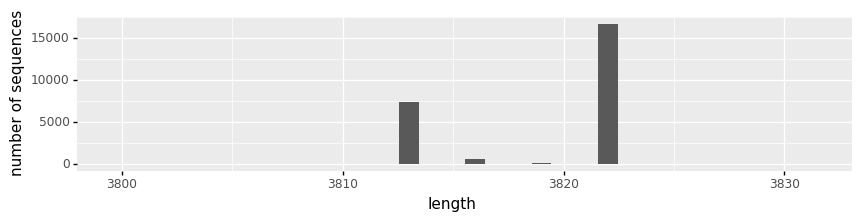


Only keeping spikes with lengths between 3800 and 3900
Here are number of sequences with valid and invalid lengths:


,n_sequences
valid_length,
True,24987



Distribution of lengths for sequences with valid and invalid lengths; dotted red lines delimit valid lengths:


C:\Users\fengl\AppData\Roaming\Python\Python39\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\fengl\AppData\Roaming\Python\Python39\site-packages\plotnine\facets\facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
C:\Users\fengl\AppData\Roaming\Python\Python39\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\fengl\AppData\Roaming\Python\Python39\site-packages\plotnine\facets\facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
C:\Users\fengl\AppData\Roaming\Python\Python39\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed f

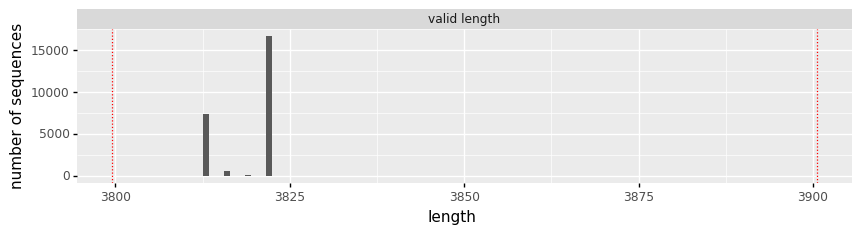

In [25]:
print('Distribution of length for all spikes:')
p = (ggplot(spikes_df) +
     aes('length') +
     geom_bar() +
     ylab('number of sequences') +
     theme(figure_size=(10, 2))
     )
fig = p.draw()
display(fig)
plt.close(fig)

#min_length, max_length = 1260, 1276
min_length, max_length = 3800, 3900
print(f"\nOnly keeping spikes with lengths between {min_length} and {max_length}")
spikes_df = (
    spikes_df
    .assign(valid_length=lambda x: (min_length <= x['length']) & (x['length'] <= max_length))
    )

print('Here are number of sequences with valid and invalid lengths:')
display(HTML(spikes_df
             .groupby('valid_length')
             .aggregate(n_sequences=pd.NamedAgg('seqrecord', 'count'))
             .to_html()
             ))

print('\nDistribution of lengths for sequences with valid and invalid lengths; '
      'dotted red lines delimit valid lengths:')
p = (ggplot(spikes_df
            .assign(valid_length=lambda x: x['valid_length'].map({True: 'valid length',
                                                                  False: 'invalid length'}))
            ) +
     aes('length') +
     geom_bar() +
     ylab('number of sequences') +
     theme(figure_size=(10, 2), subplots_adjust={'wspace': 0.2}) +
     facet_wrap('~ valid_length', scales='free') +
     geom_vline(xintercept=min_length - 0.5, color='red', linetype='dotted') +
     geom_vline(xintercept=max_length + 0.5, color='red', linetype='dotted')
     )
fig = p.draw()
display(fig)
plt.close(fig)

spikes_df = spikes_df.query('valid_length')

In [26]:
max_ambiguous = 100
print(f"Filtering sequences with > {max_ambiguous} ambiguous residues")
spikes_df = (
    spikes_df
    .assign(excess_ambiguous=lambda x: x['n_ambiguous'] > max_ambiguous)
    )
display(HTML(
    spikes_df
    .groupby('excess_ambiguous')
    .aggregate(n_sequences=pd.NamedAgg('seqrecord', 'count'))
    .to_html()
    ))


Filtering sequences with > 100 ambiguous residues


,n_sequences
excess_ambiguous,
False,24987


In [31]:
print(f"Reading reference nucleotide sequence in {config['wildtype_sequence']}")
refseq = Bio.SeqIO.read(config['wildtype_sequence'], 'fasta')

refprotfile = os.path.join(config['gisaid_mutations_dir'], 'reference_RBD.fasta')
print(f"Writing protein translation of reference sequence to {refprotfile}")
#refseq.seq = refseq.seq.translate()
_ = Bio.SeqIO.write(refseq, refprotfile, 'fasta')

Reading reference nucleotide sequence in data/wildtype_sequence.fasta
Writing protein translation of reference sequence to results/GISAID_mutations\reference_RBD.fasta


In [32]:
spikes_file = os.path.join(config['gisaid_mutations_dir'],
                           'human_full-length_spikes.fasta')
print(f"Writing the spikes to {spikes_file}")
_ = Bio.SeqIO.write(spikes_df['seqrecord'].tolist(), spikes_file, 'fasta')

Writing the spikes to results/GISAID_mutations\human_full-length_spikes.fasta


In [39]:
print(refseq.seq)
print(refseq.description)
type(refseq.seq)

AATATCACGAACCTTTGTCCTTTCGGTGAGGTCTTCAATGCTACTAGATTCGCATCCGTGTATGCATGGAATAGAAAGAGAATTAGTAATTGTGTAGCGGACTACTCTGTACTTTATAACTCCGCCTCCTTCTCCACATTCAAGTGTTACGGTGTATCTCCCACCAAGTTGAATGATCTATGCTTTACAAACGTTTACGCCGATAGTTTCGTAATTAGAGGCGATGAAGTGCGTCAGATCGCACCAGGCCAGACGGGCAAGATAGCAGACTATAATTATAAGCTGCCTGATGACTTCACCGGCTGTGTGATAGCTTGGAACTCAAATAATCTAGATTCCAAGGTGGGAGGCAATTACAATTATTTGTACCGTCTGTTCCGTAAAAGCAATTTGAAACCATTTGAAAGAGACATTAGCACTGAAATTTATCAAGCAGGGTCCACCCCGTGCAACGGCGTAGAAGGCTTTAACTGTTATTTCCCATTACAGTCTTATGGTTTCCAACCTACGAACGGAGTCGGGTATCAGCCGTACAGGGTTGTGGTTCTTTCATTTGAACTGCTGCACGCGCCCGCAACCGTATGCGGGCCGAAGAAATCAACG
SARS-CoV-2


Bio.Seq.Seq

In [52]:
chunksize = 50000

aligned_rbds = []

for i in range(0, len(spikes_df), chunksize):
    spikes_file = os.path.join(config['gisaid_mutations_dir'],
                               f"human_full-length_spikes_{i + 1}-to-{i + chunksize}.fasta")
    print(f"Writing spikes {i + 1} to {i + chunksize} to {spikes_file}")
    _ = Bio.SeqIO.write(spikes_df['seqrecord'].tolist()[i: i + chunksize], spikes_file, 'fasta')
    print('Now aligning these sequences...')
    #cmds = ['mafft', '--auto', '--thread', str(config['max_cpus']),
    #        '--keeplength', '--addfragments', spikes_file, refprotfile]

    cmds = ['D:\mafft-win\mafft.bat', '--auto', '--thread', '-1',
            '--keeplength', '--addfragments', spikes_file, refprotfile]

    res = subprocess.run(cmds, capture_output=True)
    if res.returncode:
        raise RuntimeError(f"Error in alignment:\n{res.stderr}")
    else:
        print('Alignment complete.\n')
        with io.StringIO(res.stdout.decode('utf-8')) as f:
            iseqs = list(Bio.SeqIO.parse(f, 'fasta'))
            
            # What mafft created are all lowercase sequence
            for iseq in iseqs:
                iseq.seq = iseq.seq.upper()
    
            # remove reference sequence, which should be first in file
            print(iseqs[0].seq)
            print(iseqs[0].description)
            assert iseqs[0].seq == refseq.seq and iseqs[0].description == refseq.description
            iseqs = iseqs[1:]
            assert len(iseqs) == min(chunksize, len(spikes_df) - i)
            aligned_rbds += iseqs
            
assert len(aligned_rbds) == len(spikes_df)

Writing spikes 1 to 50000 to results/GISAID_mutations\human_full-length_spikes_1-to-50000.fasta
Now aligning these sequences...
Alignment complete.

AATATCACGAACCTTTGTCCTTTCGGTGAGGTCTTCAATGCTACTAGATTCGCATCCGTGTATGCATGGAATAGAAAGAGAATTAGTAATTGTGTAGCGGACTACTCTGTACTTTATAACTCCGCCTCCTTCTCCACATTCAAGTGTTACGGTGTATCTCCCACCAAGTTGAATGATCTATGCTTTACAAACGTTTACGCCGATAGTTTCGTAATTAGAGGCGATGAAGTGCGTCAGATCGCACCAGGCCAGACGGGCAAGATAGCAGACTATAATTATAAGCTGCCTGATGACTTCACCGGCTGTGTGATAGCTTGGAACTCAAATAATCTAGATTCCAAGGTGGGAGGCAATTACAATTATTTGTACCGTCTGTTCCGTAAAAGCAATTTGAAACCATTTGAAAGAGACATTAGCACTGAAATTTATCAAGCAGGGTCCACCCCGTGCAACGGCGTAGAAGGCTTTAACTGTTATTTCCCATTACAGTCTTATGGTTTCCAACCTACGAACGGAGTCGGGTATCAGCCGTACAGGGTTGTGGTTCTTTCATTTGAACTGCTGCACGCGCCCGCAACCGTATGCGGGCCGAAGAAATCAACG
SARS-CoV-2


In [92]:
rbd_df = (
    pd.DataFrame({'seqrecord': aligned_rbds})
    .assign(description=lambda x: x['seqrecord'].map(lambda rec: rec.description),
            country=lambda x: x['description'].str.split('|').str[-1],
            host=lambda x: x['description'].str.split('|').str[6].str.strip(),
            length=lambda x: x['seqrecord'].map(len),
            n_ambiguous=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('X') + rec.seq.count('x')),
            n_gaps=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('-')),
            all_valid_aas=lambda x: x['seqrecord'].map(lambda rec: re.fullmatch(f"[{protein_letters}]+",
                                                                                str(rec.seq)) is not None),
            )
    )

assert all(rbd_df['length'] == len(refseq))

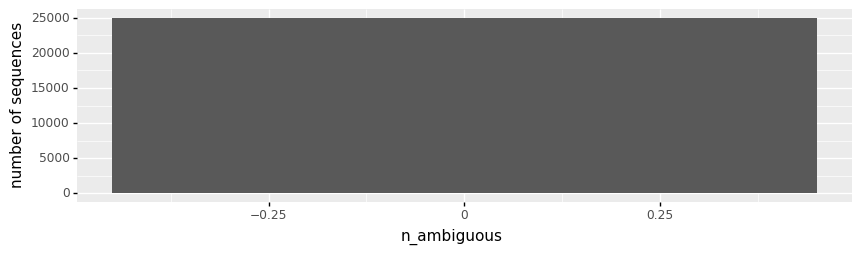

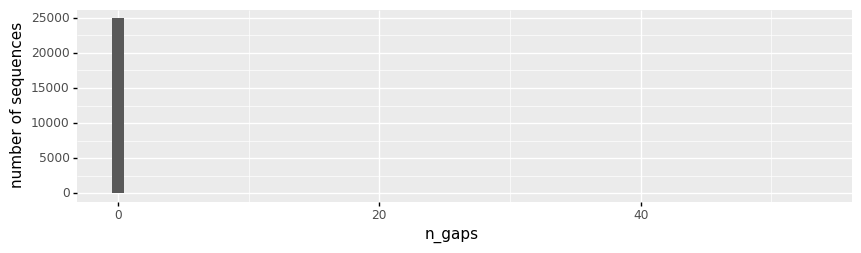

In [93]:
for prop in ['n_ambiguous', 'n_gaps']:
    p = (ggplot(rbd_df) +
         aes(prop) +
         ylab('number of sequences') +
         theme(figure_size=(10, 2.5)) +
         geom_bar()
         )
    _ = p.draw()

In [94]:
protein_letters



'ACDEFGHIKLMNPQRSTVWY'

In [95]:
rbd_df = rbd_df.query('n_ambiguous == 0').query('n_gaps == 0')
assert rbd_df['all_valid_aas'].all()
print(f"Retained {len(rbd_df)} RBDs.")

Retained 24944 RBDs.


In [96]:
rbd_df

,seqrecord,description,country,host,length,n_ambiguous,n_gaps,all_valid_aas
0,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Wuhan/WIV04/2019|2019-12-30|EPI_...,China,Human,603,0,0,True
1,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Spain/CN-IBV-97016118/2021|2021-...,Canary Islands,Human,603,0,0,True
2,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/France/HDF-IPP02628/2021|2021-01...,France,Human,603,0,0,True
3,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Switzerland/SO-ETHZ-460715/2021|...,Switzerland,Human,603,0,0,True
4,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Switzerland/JU-ETHZ-470314/2021|...,Switzerland,Human,603,0,0,True
...,...,...,...,...,...,...,...,...
24982,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Denmark/DCGC-44158/2021|2021-02-...,Denmark,Human,603,0,0,True
24983,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Japan/TKYN00044/2020|2020-11-00|...,Japan,Human,603,0,0,True
24984,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/England/MILK-12619A3/2021|2021-0...,United Kingdom,Human,603,0,0,True
24985,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Denmark/DCGC-43520/2021|2021-02-...,Denmark,Human,603,0,0,True


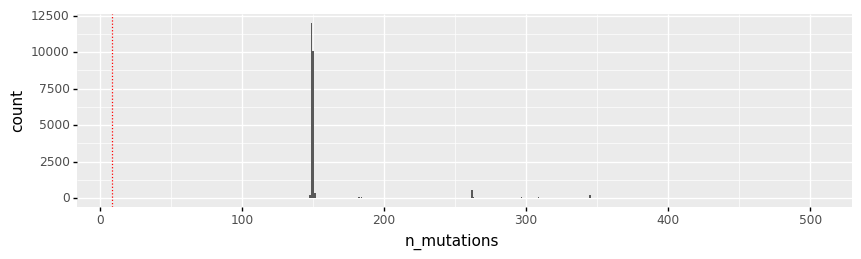

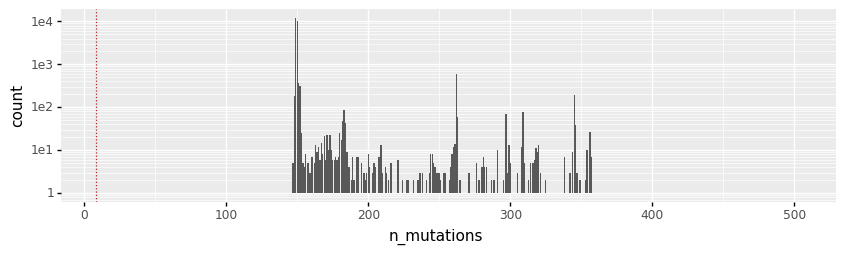

In [100]:
max_muts = 8

refseq_str = str(refseq.seq)
rbd_df = (
    rbd_df
    .assign(seq=lambda x: x['seqrecord'].map(lambda rec: str(rec.seq)),
            n_mutations=lambda x: x['seq'].map(lambda s: sum(x != y for x, y in zip(s, refseq_str))))
    )

p = (ggplot(rbd_df) +
     aes('n_mutations') +
     geom_bar() +
     theme(figure_size=(10, 2.5)) +
     geom_vline(xintercept=max_muts + 0.5, color='red', linetype='dotted')
     )
_ = p.draw()
_ = (p + scale_y_log10()).draw()



In [102]:
print('refseq:' + refseq_str)



print(' first record seq:'+ rbd_df.iloc[0]['seq'])
print(' first record n_mutations ' + str(rbd_df.iloc[0]['n_mutations']))

refseq:AATATCACGAACCTTTGTCCTTTCGGTGAGGTCTTCAATGCTACTAGATTCGCATCCGTGTATGCATGGAATAGAAAGAGAATTAGTAATTGTGTAGCGGACTACTCTGTACTTTATAACTCCGCCTCCTTCTCCACATTCAAGTGTTACGGTGTATCTCCCACCAAGTTGAATGATCTATGCTTTACAAACGTTTACGCCGATAGTTTCGTAATTAGAGGCGATGAAGTGCGTCAGATCGCACCAGGCCAGACGGGCAAGATAGCAGACTATAATTATAAGCTGCCTGATGACTTCACCGGCTGTGTGATAGCTTGGAACTCAAATAATCTAGATTCCAAGGTGGGAGGCAATTACAATTATTTGTACCGTCTGTTCCGTAAAAGCAATTTGAAACCATTTGAAAGAGACATTAGCACTGAAATTTATCAAGCAGGGTCCACCCCGTGCAACGGCGTAGAAGGCTTTAACTGTTATTTCCCATTACAGTCTTATGGTTTCCAACCTACGAACGGAGTCGGGTATCAGCCGTACAGGGTTGTGGTTCTTTCATTTGAACTGCTGCACGCGCCCGCAACCGTATGCGGGCCGAAGAAATCAACG
 first record seq:AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAAAGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAG

In [103]:
rbd_df['n_mutations'].describe()

count    24944.000000
mean       158.093690
std         33.829084
min        147.000000
25%        149.000000
50%        150.000000
75%        150.000000
max        504.000000
Name: n_mutations, dtype: float64

In [104]:
max_muts=150

rbd_df = rbd_df.query('n_mutations <= @max_muts')

In [105]:
rbd_df

,seqrecord,description,country,host,length,n_ambiguous,n_gaps,all_valid_aas,seq,n_mutations
0,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Wuhan/WIV04/2019|2019-12-30|EPI_...,China,Human,603,0,0,True,AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCA...,149
1,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Spain/CN-IBV-97016118/2021|2021-...,Canary Islands,Human,603,0,0,True,AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCA...,150
2,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/France/HDF-IPP02628/2021|2021-01...,France,Human,603,0,0,True,AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCA...,150
5,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Canada/QC-L00254708/2020|2020-04...,Canada,Human,603,0,0,True,AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCA...,149
8,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/USA/MI-UM-10038285263/2021|2021-...,USA,Human,603,0,0,True,AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCA...,150
...,...,...,...,...,...,...,...,...,...,...
24981,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Switzerland/GE-33197534/2021|202...,Switzerland,Human,603,0,0,True,AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCA...,149
24982,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Denmark/DCGC-44158/2021|2021-02-...,Denmark,Human,603,0,0,True,AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCA...,150
24983,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/Japan/TKYN00044/2020|2020-11-00|...,Japan,Human,603,0,0,True,AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCA...,149
24984,"(A, A, T, A, T, T, A, C, A, A, A, C, T, T, G, ...",Spike|hCoV-19/England/MILK-12619A3/2021|2021-0...,United Kingdom,Human,603,0,0,True,AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCA...,150


In [106]:
print(f"Overall, there are {len(rbd_df)} aligned RBDs that passed filters.")

rbd_alignment_file = os.path.join(config['gisaid_mutations_dir'], 'RBD_alignment.fasta')
print(f"Writing alignment to {rbd_alignment_file}")
_ = Bio.SeqIO.write(rbd_df['seqrecord'].tolist(), rbd_alignment_file, 'fasta')

Overall, there are 22257 aligned RBDs that passed filters.
Writing alignment to results/GISAID_mutations\RBD_alignment.fasta


In [107]:
records = []
for tup in rbd_df[['seq', 'country']].itertuples():
    for isite, (mut, wt) in enumerate(zip(tup.seq, refseq_str), start=1):
        if mut != wt:
            records.append((isite, isite + config['site_number_offset'], wt, mut, tup.country))
            
muts_df = (pd.DataFrame.from_records(records,
                                     columns=['isite', 'site', 'wildtype', 'mutant', 'country'])
           .groupby(['isite', 'site', 'wildtype', 'mutant'])
           .aggregate(count=pd.NamedAgg('country', 'count'),
                      n_countries=pd.NamedAgg('country', 'nunique'))
           .reset_index()
           .sort_values('count', ascending=False)
           .assign(frequency=lambda x: x['count'] / len(rbd_df))
           )

print('Here are first few lines of mutation counts data frame:')
display(HTML(muts_df.head(n=15).to_html(index=False)))

Here are first few lines of mutation counts data frame:


isite,site,wildtype,mutant,count,n_countries,frequency
6,336,C,T,22257,76,1.0
189,519,A,T,22257,76,1.0
391,721,T,C,22257,76,1.0
171,501,G,A,22257,76,1.0
405,735,A,G,22257,76,1.0
415,745,A,T,22257,76,1.0
416,746,G,C,22257,76,1.0
438,768,G,T,22257,76,1.0
294,624,C,T,22257,76,1.0
126,456,C,A,22257,76,1.0


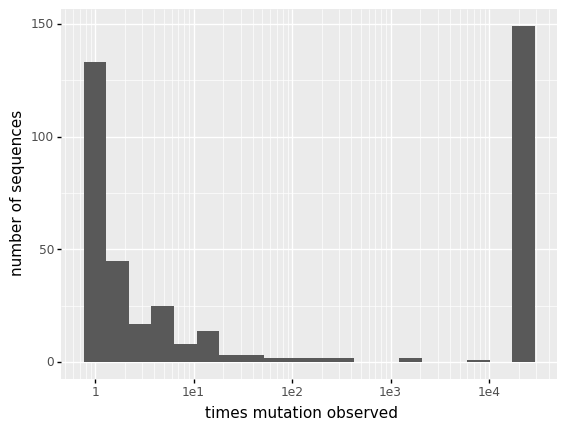

In [108]:
p = (ggplot(muts_df) +
     aes('count') +
     geom_histogram(bins=20) +
     scale_x_log10() +
     ylab('number of sequences') +
     xlab('times mutation observed')
     )

_ = p.draw()

In [109]:
print(f"Writing mutation counts to {config['gisaid_mutations_dir']}")
muts_df.to_csv(config['gisaid_mutation_counts'], index=False)

Writing mutation counts to results/GISAID_mutations
